# Testing Snowplow Algorithm

Consideration: if no unserviced edges except for u-turning, consider probabilistically choosing to traverse a serviced edge to escape a local area.

In [1]:
import os
%load_ext autoreload
%autoreload 2

In [2]:
import Snowplow_Routing_Middleton.dual_graphs as dual_graphs
import Snowplow_Routing_Middleton.construction as construction
import Snowplow_Routing_Middleton.plotting as plotting
import Snowplow_Routing_Middleton.local_search as local_search
import Snowplow_Routing_Middleton.initialize as initialize
import Snowplow_Routing_Middleton.params as params
import Snowplow_Routing_Middleton.sectioning as sectioning
import Snowplow_Routing_Middleton.costs as costs


from Snowplow_Routing_Middleton.shortest_paths import ShortestPaths
from Snowplow_Routing_Middleton.crossover import apply_crossover
from Snowplow_Routing_Middleton.genetic import run_genetic
from Snowplow_Routing_Middleton.solution import Solution
from Snowplow_Routing_Middleton.costs import routes_cost, calculate_time_deadheading
from Snowplow_Routing_Middleton.routes_representations import create_full_routes_with_returns
from Snowplow_Routing_Middleton.turns import turn_direction_count

import pandas as pd
import osmnx as ox
import folium
import folium.plugins
import networkx as nx
import pickle
import matplotlib.pyplot as plt


Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

In [3]:
toyEdgeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\edges.csv"
toyNodeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\nodes.csv"

In [4]:
curr_path = os.path.abspath("")
parent_path = os.path.split(curr_path)[0]

In [5]:
instance = "sectionedfullstreets"

polygon_path = os.path.join(parent_path, "graph_data\\individual_sections\\route1_blue.gpkg")

match instance:
    case "smallstreets":
        G = initialize.create_small_streets()
    case "fullstreets":
        G = initialize.create_full_streets()
    case "smalltoy":
        G = initialize.create_small_toy(toyEdgeFile, toyNodeFile)
    case "sectionedfullstreets":
        G = sectioning.section_component(polygon_path, False)
    case _:
        print("Invalid instance name")
     

In [6]:
ox.graph_to_gdfs(G, nodes=False, edges=True).explore()

Update depot

In [7]:
if instance == "fullstreets" or instance == "sectionedfullstreets":
    params.DEPOT = params.find_depot(G)[0]
else:
    params.DEPOT = 0
params.DEPOT

136

In [8]:
approach = "genetic"

if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, params.DEPOT)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



Adding depot source 136


In [9]:
print(G)
print(G_DUAL)

MultiDiGraph with 170 nodes and 637 edges
MultiDiGraph with 638 nodes and 3521 edges


In [10]:
blue_shortest_paths_folderpath  = os.path.join(parent_path, "graph_data\\shortest_paths\\route1_blue")


In [11]:
sp = ShortestPaths(G_DUAL, True, False, blue_shortest_paths_folderpath)

In [12]:
r, rreq = construction.route_generation(G, sp, params.DEPOT)

Test Local Search

In [13]:
required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, params.DEPOT), 0)

print(S_first.cost)


27128.586364313564


In [14]:
_, head = local_search.individual_to_linked_list(rreq, params.DEPOT)
print("Linked list costs:", costs.routes_cost_linked_list(G, sp, head, params.DEPOT))
print("Normal cost:", routes_cost(G, sp, rreq, params.DEPOT))

Linked list costs: 27128.586364313564
Normal cost: 27128.586364313564


In [15]:
serviced = set()
for route in S_first.routes:
    for edge in route:
        serviced.add(edge[:3])
print(len(serviced), len(required_edges))

563 563


In [16]:
S_new = local_search.local_improve(S_first, G, sp, required_edges, params.DEPOT, threshold=1)
print(routes_cost(G, sp, S_new.routes, params.DEPOT))
for route in S_new.routes:
    for routestep in route:
        print(routestep)
    print("***")

Modifed  17 times
26307.26263649277
(138, 137, 1)
(137, 138, 0)
(136, 137, 0)
(137, 138, 1)
(138, 137, 0)
(137, 139, 0)
(139, 140, 0)
(140, 141, 0)
(141, 151, 0)
(151, 138, 0)
(138, 136, 0)
(136, 135, 0)
(135, 116, 0)
(116, 68, 0)
(68, 67, 0)
(67, 115, 0)
(115, 83, 0)
(83, 81, 0)
(81, 79, 0)
(79, 64, 0)
(86, 71, 0)
(71, 32, 0)
(32, 69, 0)
(69, 69, 0)
(69, 32, 0)
(32, 71, 0)
(71, 152, 0)
(152, 22, 0)
(22, 148, 0)
(148, 60, 0)
(60, 61, 0)
(61, 62, 0)
(62, 63, 0)
(63, 84, 0)
(84, 81, 1)
(79, 77, 0)
(77, 79, 0)
(79, 63, 0)
(63, 85, 0)
(85, 63, 0)
(63, 79, 0)
(79, 77, 1)
(77, 79, 1)
(79, 63, 1)
(63, 85, 1)
(85, 63, 1)
(63, 79, 1)
(79, 77, 2)
(77, 79, 2)
(79, 63, 2)
(63, 85, 2)
(85, 63, 2)
(63, 79, 2)
(86, 152, 0)
(148, 61, 0)
(62, 64, 0)
(71, 32, 1)
(32, 69, 1)
(69, 32, 1)
(32, 16, 2)
(16, 12, 0)
(12, 11, 0)
(11, 8, 0)
(8, 10, 0)
(10, 14, 0)
(14, 10, 2)
(10, 8, 0)
(8, 9, 0)
(9, 12, 0)
(12, 16, 0)
(16, 32, 0)
(32, 70, 0)
(70, 92, 0)
(92, 95, 0)
(95, 99, 0)
(99, 96, 0)
(96, 160, 0)
(160, 123,

{'straight': 354, 'u-turn': 126, 'right': 106, 'left': 51, 'sharp left': 36, 'sharp right': 47}


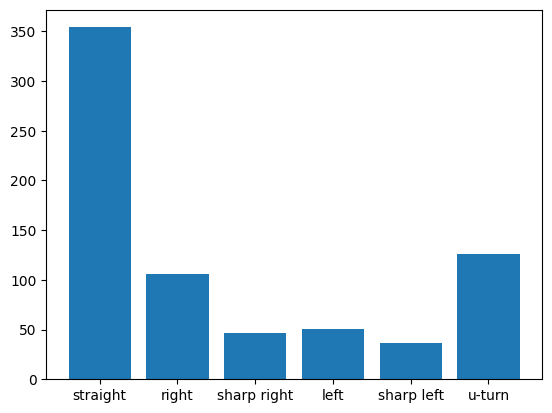

In [17]:
full_routes = create_full_routes_with_returns(G, sp, rreq, params.DEPOT)
counts, x_axis, y_axis = turn_direction_count(G_DUAL, full_routes)
print(counts)
plt.bar(x_axis, y_axis)
plotting.plot_moving_routes_folium(G, full_routes, label_color="blue", path_color="blue", m=None)

In [21]:
s1, s1req = construction.route_generation(G, sp, params.DEPOT)
S1 = Solution(s1req, dict(), routes_cost(G, sp, s1req, params.DEPOT), 0)
S1 = local_search.local_improve(S1, G, sp, required_edges, params.DEPOT, threshold=1)

s2, s2req = construction.route_generation(G, sp, params.DEPOT)
S2 = Solution(s2req, dict(), routes_cost(G, sp, s2req, params.DEPOT), 0)
S2 = local_search.local_improve(S2, G, sp, required_edges, params.DEPOT, threshold=1)

KeyboardInterrupt: 

In [19]:
routes_0 = apply_crossover(G, sp, S1.routes, S2.routes, params.DEPOT)
# idea for crossover: don't crossover a whole subsection of routes, but rather a fixed chunk (say 20-30 routesteps) of a route. This would significantly improve computation speed
new_cost = routes_cost(G, sp, routes_0, params.DEPOT)
S0 = Solution(routes_0, dict(), new_cost, 0)

Length of routes0 1
removing 563 [(138, 137, 0), (137, 138, 1), (136, 137, 0), (137, 138, 0), (138, 137, 1), (137, 139, 0), (139, 140, 0), (140, 141, 0), (141, 151, 0), (151, 138, 0), (138, 136, 0), (136, 135, 0), (135, 116, 0), (116, 68, 0), (68, 67, 0), (67, 115, 0), (115, 83, 0), (83, 81, 0), (81, 79, 0), (79, 64, 0), (86, 71, 0), (71, 32, 0), (32, 69, 0), (69, 69, 0), (69, 32, 0), (32, 71, 0), (71, 152, 0), (148, 61, 0), (71, 32, 1), (32, 69, 1), (69, 32, 1), (32, 71, 1), (71, 32, 2), (32, 69, 2), (69, 32, 2), (32, 71, 2), (32, 70, 0), (70, 92, 0), (92, 95, 0), (95, 99, 0), (99, 96, 0), (96, 160, 0), (160, 123, 0), (123, 127, 0), (127, 122, 0), (122, 102, 0), (102, 121, 0), (121, 126, 0), (126, 130, 0), (130, 168, 0), (168, 168, 0), (168, 130, 0), (130, 129, 0), (129, 167, 0), (167, 169, 0), (169, 166, 0), (166, 128, 0), (128, 125, 0), (125, 121, 0), (121, 102, 0), (102, 122, 0), (122, 127, 0), (127, 131, 0), (131, 103, 0), (103, 104, 0), (104, 124, 0), (124, 99, 0), (99, 90, 0), (

In [1]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp, params.DEPOT)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")

NameError: name 'run_genetic' is not defined

In [71]:
first_full_route = create_full_routes_with_returns(G, sp, rreq, params.DEPOT)
time_seconds_first = costs.route_travel_time(G, first_full_route, params.DEPOT)
print("First route cost", routes_cost(G, sp, rreq, params.DEPOT))
print("First route travel time hours", time_seconds_first/3600)
print("First route deadhead time hours", calculate_time_deadheading(rreq, sp, params.DEPOT)/3600)

First route cost 33628.65268563319
First route travel time hours 7.004569196573838
First route deadhead time hours 1.779240086192093


In [72]:
final_full_route = create_full_routes_with_returns(G, sp, sol.routes, params.DEPOT)
time_seconds = costs.route_travel_time(G, final_full_route, params.DEPOT)
# Display costs and travel time
print("Final Routes cost", sol.cost)
print("Final Travel time hours", time_seconds/3600)
print("Final Deadhead time hours", calculate_time_deadheading(sol.routes, sp, params.DEPOT)/3600)

Final Routes cost 31170.18627534145
Final Travel time hours 6.629826689971492
Final Deadhead time hours 1.3129650963373898


In [75]:
plotting.plot_moving_routes_folium(G, final_full_route, label_color="blue", path_color="blue", m=None)